In [2]:
from pathlib import Path

from flax.training import train_state
from jax import jit, value_and_grad, vmap
import jax.numpy as jnp
import jax.random as jr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import optax
import tensorflow_probability.substrates.jax as tfp
import wfdb

from mlscience_ekgs.settings import ptb_path

tfd = tfp.distributions
MVN = tfd.MultivariateNormalTriL
MVD = tfd.MultivariateNormalDiag
Normal = tfd.Normal

In [3]:
def compute_electrode_electric_potential(s, p, r, kappa=0.2):
    """Compute the electric potential due to a point charge.
        s: 3-d location of the dipole
        p: 3-d moment of the dipole
        r: 3-d location of the electrode
        kappa: electrical conductivity of the torso
        
    Returns:
        e_p: electric potential at the electrode
    """
    d = r - s # 3-d displacement vector
    e_p = 1/(4*jnp.pi*kappa) * (d @ p)/jnp.linalg.norm(d)**3

    return e_p


def compute_lead_observations(eps):
    """Compute the 12d lead observations given 
    electric potentials for the 9 electrodes.
        eps: 9-d electric potential values.
    
    Returns:
        leads: 12-d lead observations.
    """
    Oe = jnp.array([
        [1., -1., 0.],
        [0., -1., 1.],
        [-1., 0., 1.]
    ])
    Oa = jnp.array([
        [-0.5, 1., -0.5],
        [1., -0.5, -0.5],
        [-0.5, -0.5, 1.]
    ])
    Ov = -1/3 * jnp.ones((6, 3))
    Oh = jnp.vstack((jnp.zeros((6, 6)), jnp.eye(6)))
    Omat = jnp.hstack((jnp.vstack((Oe, Oa, Ov)), Oh))
    leads = Omat @ eps

    return leads

In [4]:
# Example
n_electrodes = 9
ss = jr.normal(jr.PRNGKey(0), (n_electrodes, 3,))
ps = jr.normal(jr.PRNGKey(1), (n_electrodes, 3,))
rs = jr.normal(jr.PRNGKey(2), (n_electrodes, 3,))

compute_lead_observations(vmap(compute_electrode_electric_potential)(ss, ps, rs))

Array([-0.08210497,  0.05404872,  0.13615368,  0.01402812, -0.10912932,
        0.09510121, -0.04704605, -0.02942227,  0.05475863, -0.2745333 ,
        0.09258957,  0.03223535], dtype=float32)

# 1. Load Data

In [5]:
## Reference: https://github.com/arjung128/mi_detection/blob/master/CNQ_model_split_by_patient.py
# files_unhealthy, files_healthy, result = [], [], []

# for file_ in lines:
#     file_path = Path(ptb_path, f"{file_[:-1]}.hea")
    
#     # read header to determine class
#     if 'Myocardial infarction' in open(file_path).read():
#         files_unhealthy.append(file_)
#         result.append(0)
        
#     if 'Healthy control' in open(file_path).read():
#         files_healthy.append(file_)
#         result.append(1)

# healthy_train = files_healthy[:int(0.8*len(files_healthy))]

In [6]:
channels = ['i', 'ii', 'iii', 'avr', 'avl', 'avf', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6',]

def load_12ch_data(data_idx=0, starting_idx=0, length=10_000, channels=channels):
    """Load 12-lead ECG data from the PTB database.
        data_idx: index of the data file to load.
        starting_idx: index of the starting sample.
        length: number of samples to load.
        
    Returns:
        leads: 12-d lead observations.
    """
    with open(Path(ptb_path, "RECORDS")) as fp:
        data_list = fp.readlines()
    
    curr_data = data_list[data_idx].strip()
    channel_data, _ = wfdb.rdsamp(Path(ptb_path, curr_data), channel_names=channels)
    channel_data = channel_data.T
    channel_data = channel_data[:, starting_idx:starting_idx+length]
    print(channel_data.shape)
    
    return channel_data

In [7]:
n_steps = 10_000
channel_data = load_12ch_data(length=n_steps)

(12, 10000)


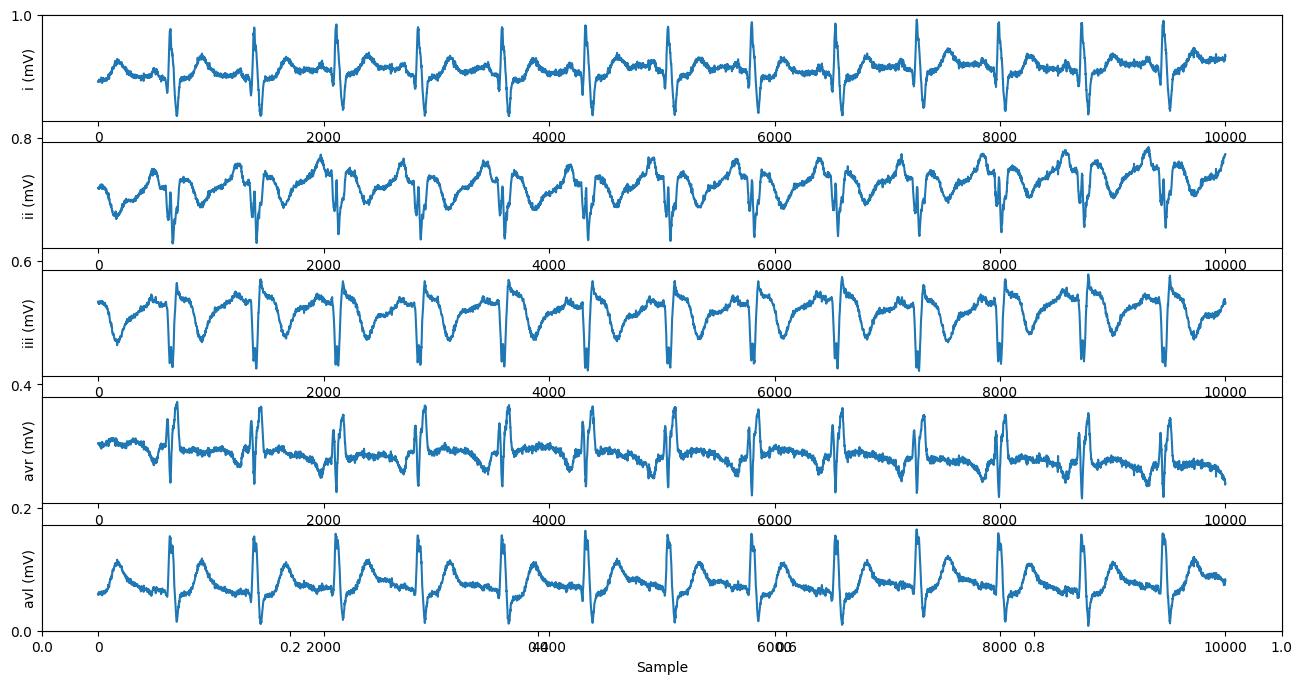

In [8]:
fig, ax = plt.subplots(figsize=(16, 8))
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1])

# Create each subplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)
axes = [ax0, ax1, ax2, ax3, ax4]


for i, (ax, data) in enumerate(zip(axes, channel_data[:5])):
    ax.plot(data)
    ax.set_ylabel(f"{channels[i]} (mV)")
    ax.set_yticks([])
    ax.set_xlabel("Sample");

In [147]:
# Mask first 1000 steps of first channel
ch1_data = channel_data[0]
ch1_data = jnp.where(jnp.arange(10_000) < 1000, jnp.nan, ch1_data)
channel_data_masked = jnp.vstack((ch1_data, channel_data[1:]))

# Mask 1000 to 2000 steps of the fourth channel
ch4_data = channel_data_masked[3]
ch4_data = jnp.where((jnp.arange(10_000) >= 1000) & (jnp.arange(10_000) < 2000), jnp.nan, ch4_data)
channel_data_masked = jnp.vstack((channel_data_masked[:3], ch4_data, channel_data_masked[4:]))

# Mask 4000 to 6000 steps of the third channel
ch3_data = channel_data_masked[2]
ch3_data = jnp.where((jnp.arange(10_000) >= 4000) & (jnp.arange(10_000) < 6000), jnp.nan, ch3_data)
channel_data_masked = jnp.vstack((channel_data_masked[:1], ch3_data, channel_data_masked[2:]))

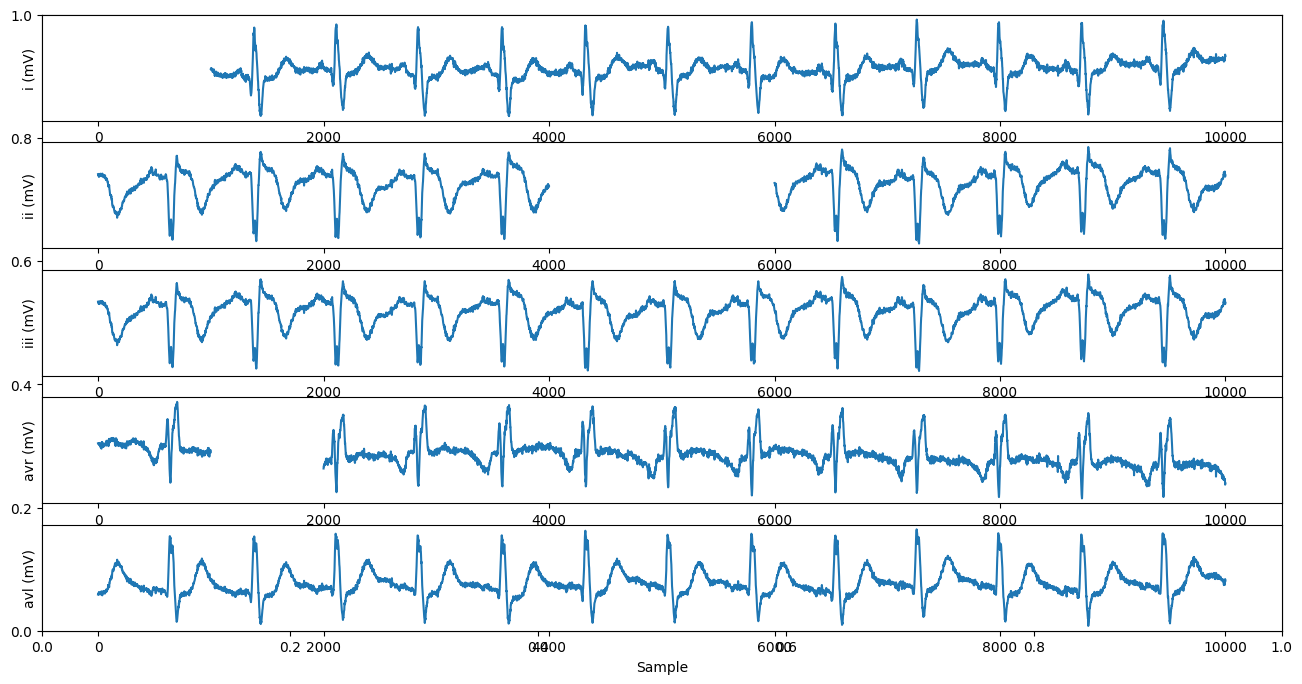

In [148]:
fig, ax = plt.subplots(figsize=(16, 8))
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1])

# Create each subplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)
axes = [ax0, ax1, ax2, ax3, ax4]


for i, (ax, data) in enumerate(zip(axes, channel_data_masked[:5])):
    ax.plot(data)
    ax.set_ylabel(f"{channels[i]} (mV)")
    ax.set_yticks([])
    ax.set_xlabel("Sample");

# 2. Inference

## 2.1 Kappa fixed to 0.2

In [149]:
keys = jr.split(jr.PRNGKey(0), 3)
n_electrodes = 9
r_var, s_var, p_var = 1.0, 1.0, 1.0
r_init = jr.normal(keys[0], (n_electrodes, 3))
s_init, p_init = \
    jr.normal(keys[1], (n_steps, 3)), jr.normal(keys[2], (n_steps, 3))
r_prior = MVN(loc=r_init, scale_tril=r_var*jnp.eye(3))
s_prior = MVN(loc=s_init, scale_tril=s_var*jnp.eye(3))
p_prior = MVD(loc=p_init, scale_diag=p_var*jnp.ones(3))

z_init = jnp.hstack([s_init, p_init])
# params_init = jnp.hstack((r_init, s_init, p_init))

In [176]:
def compute_log_likelihood(params, obs, obs_mask, obs_scale=0.1):
    """Compute the log likelihood of the model.
        r_params: mean estimate of 9 electrode locations.
        z_params: mean estimate of dipole location and moment for each timestep.
        obs: observation.
        
    Returns:
        log_likelihood: log likelihood of the model.
    """
    r, s, p = params["r"], params["s"], params["p"]
    eps = vmap(
        vmap(compute_electrode_electric_potential, (0, 0, None)), (None, None, 0)
    )(s, p, r)
    leads_pred = compute_lead_observations(eps)
    ll_fn = lambda pred, obs: Normal(loc=pred, scale=obs_scale).log_prob(obs)
    log_likelihood = vmap(ll_fn)(leads_pred, obs)
    log_likelihood = jnp.sum(log_likelihood * obs_mask)
    
    return log_likelihood

def compute_log_joint_prob(params, obs, obs_mask, obs_scale=0.01,
                           r_prior=r_prior, s_prior=s_prior, p_prior=p_prior):
    r, s, p = params["r"], params["s"], params["p"]
    log_likelihood = compute_log_likelihood(params, obs, obs_mask, obs_scale)
    # Assume Gaussian prior
    log_prior_r = r_prior.log_prob(r).sum()
    log_prior_s = s_prior.log_prob(s).sum()
    log_prior_p = p_prior.log_prob(p).sum()
    log_prior = log_prior_r + log_prior_s + log_prior_p
    log_joint = log_likelihood + log_prior
    
    return log_joint

@jit
def update_step_logjoint(state, obs, obs_mask, obs_scale=2e-2,
                         r_prior=r_prior, s_prior=s_prior, p_prior=p_prior):
    log_joint, grads = value_and_grad(compute_log_joint_prob)(
        state.params, obs, obs_mask, obs_scale, r_prior, s_prior, p_prior
    )
    state = state.apply_gradients(grads=grads)
    
    return state, log_joint

def train_log_joint(params, obs, r_prior=r_prior, s_prior=s_prior, p_prior=p_prior,
                    obs_scale=1e-2, lr=1e-5, n_epochs=1_000):
    mask = jnp.where(jnp.isnan(obs), 0., 1.)
    obs = jnp.where(jnp.isnan(obs), 0., obs)
    
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=n_epochs//10,
        decay_steps=n_epochs,
        end_value=1e-6
    )
    optimizer = optax.adam(lr_schedule)
    state = train_state.TrainState.create(
        apply_fn=None, params=params, tx=optimizer
    )
    
    for epoch in range(n_epochs):
        state, loss = update_step_logjoint(state, obs, mask, obs_scale,
                                             r_prior, s_prior, p_prior)
        if epoch % 200 == 0:
            print(f"Epoch {epoch: >6} | Loss: {loss:>10}")
        # predictions = predict_lead_obs(state.params)
        # print(f"predictions: {predictions[:,:5]}")
        # print(f"observed: {obs[:,:5]}\n")
        # print(f"loss: {(predictions - obs)**2}")
        
    predictions = predict_lead_obs(state.params)
    
    return state

In [174]:
def predict_lead_obs(params):
    r, s, p = params["r"], params["s"], params["p"]
    eps = vmap(
        vmap(compute_electrode_electric_potential, (0, 0, None)), (None, None, 0)
    )(s, p, r)
    leads_pred = compute_lead_observations(eps)
    
    return leads_pred

def rmse_loss(params, obs, obs_mask):
    leads_pred = predict_lead_obs(params)
    # print(leads_pred)
    loss = (leads_pred - obs)**2
    loss = loss * obs_mask
    loss = jnp.sqrt(loss.mean())
    
    return loss

@jit
def update_step_rmse(state, obs, obs_mask):
    loss, grads = value_and_grad(rmse_loss)(state.params, obs, obs_mask)
    state = state.apply_gradients(grads=grads)
    
    return state, loss

def train_rmse(params, obs, lr=1e-5, n_epochs=1_000):
    mask = jnp.where(jnp.isnan(obs), 0., 1.)
    obs = jnp.where(jnp.isnan(obs), 0., obs)
    
    predictions = predict_lead_obs(params)
    # print(f"predictions: {predictions[:,:5]}")
    # print(f"observed: {obs[:,:5]}")
    # print(f"loss: {(predictions - obs)**2}\n\n")
    
    # Train state
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=n_epochs//10,
        decay_steps=n_epochs,
        end_value=1e-6
    )
    optimizer = optax.adam(lr_schedule)
    state = train_state.TrainState.create(
        apply_fn=None, params=params, tx=optimizer
    )
    
    for epoch in range(n_epochs):
        state, loss = update_step_rmse(state, obs, mask)
        if epoch % 200 == 0:
            print(f"Epoch {epoch: >6} | Loss: {loss:>10}")
        # predictions = predict_lead_obs(state.params)
        # print(f"predictions: {predictions[:,:5]}")
        # print(f"observed: {obs[:,:5]}\n")
        # print(f"loss: {(predictions - obs)**2}")
        
    predictions = predict_lead_obs(state.params)
    
    return state

In [177]:
state_post_masked = train_log_joint(params, channel_data_masked, lr=1e-1, n_epochs=15_000)

Epoch      0 | Loss: -1145626240.0
Epoch    200 | Loss: -1.4588381849983123e+19
Epoch    400 | Loss: -2.1687821118197885e+20
Epoch    600 | Loss: -1.0750755184103528e+21
Epoch    800 | Loss: -2.3081097272011449e+21


KeyboardInterrupt: 

In [152]:
n_steps = 10_000

keys = jr.split(jr.PRNGKey(0), 3)
n_electrodes = 9
r_var, s_var, p_var = 1.0, 1.0, 1.0
r_init = jr.normal(keys[0], (n_electrodes, 3))
s_init, p_init = \
    jr.normal(keys[1], (n_steps, 3)), jr.normal(keys[2], (n_steps, 3))
r_prior = MVN(loc=r_init, scale_tril=r_var*jnp.eye(3))
s_prior = MVN(loc=s_init, scale_tril=s_var*jnp.eye(3))
p_prior = MVD(loc=p_init, scale_diag=p_var*jnp.ones(3))

z_init = jnp.hstack([s_init, p_init])
# params_init = jnp.hstack((r_init, s_init, p_init))

In [153]:
params = {
    "r": r_init,
    "s": s_init,
    "p": p_init,
}

In [127]:
state_post = train_rmse(params, channel_data[:, :n_steps], lr=1e-1, n_epochs=10_000)

Epoch      0 | Loss: 1.4545652866363525
Epoch    200 | Loss: 0.14646074175834656
Epoch    400 | Loss: 0.10894758999347687
Epoch    600 | Loss: 0.07961796969175339
Epoch    800 | Loss: 0.06255912035703659
Epoch   1000 | Loss: 0.06570703536272049
Epoch   1200 | Loss: 0.051943909376859665
Epoch   1400 | Loss: 0.04763420671224594
Epoch   1600 | Loss: 0.04394163936376572
Epoch   1800 | Loss: 0.053917307406663895
Epoch   2000 | Loss: 0.04515639320015907
Epoch   2200 | Loss: 0.04091882333159447
Epoch   2400 | Loss: 0.05174783989787102
Epoch   2600 | Loss: 0.03709832951426506
Epoch   2800 | Loss: 0.034607868641614914
Epoch   3000 | Loss: 0.033712368458509445
Epoch   3200 | Loss: 0.03127092868089676
Epoch   3400 | Loss: 0.03002791851758957
Epoch   3600 | Loss: 0.028847796842455864
Epoch   3800 | Loss: 0.02682795561850071
Epoch   4000 | Loss: 0.02661244198679924
Epoch   4200 | Loss: 0.024548782035708427
Epoch   4400 | Loss: 0.02473076805472374
Epoch   4600 | Loss: 0.022764232009649277
Epoch   48

In [178]:
state_post_masked = train_rmse(params, channel_data_masked, lr=1e-1, n_epochs=30_000)

Epoch      0 | Loss: 1.3820264339447021
Epoch    200 | Loss: 0.18293359875679016
Epoch    400 | Loss: 0.13376325368881226
Epoch    600 | Loss: 0.11169497668743134
Epoch    800 | Loss: 0.09153001755475998
Epoch   1000 | Loss: 0.07589102536439896
Epoch   1200 | Loss: 0.06677497923374176
Epoch   1400 | Loss: 0.062002215534448624
Epoch   1600 | Loss: 0.058410435914993286
Epoch   1800 | Loss: 0.05763031914830208
Epoch   2000 | Loss: 0.05412591993808746
Epoch   2200 | Loss: 0.051432859152555466
Epoch   2400 | Loss: 0.05043284222483635
Epoch   2600 | Loss: 0.04906628280878067
Epoch   2800 | Loss: 0.04758623614907265
Epoch   3000 | Loss: 0.04658697918057442
Epoch   3200 | Loss: 0.046259261667728424
Epoch   3400 | Loss: 0.04560874402523041
Epoch   3600 | Loss: 0.0449102446436882
Epoch   3800 | Loss: 0.044444601982831955
Epoch   4000 | Loss: 0.044621895998716354
Epoch   4200 | Loss: 0.043044041842222214
Epoch   4400 | Loss: 0.04331279546022415
Epoch   4600 | Loss: 0.04236079752445221
Epoch   480

In [192]:
leads_pred = predict_lead_obs(state_post.params)
leads_pred

Array([[-0.24300097, -0.24113375, -0.23989962, ...,  0.05504584,
         0.04389207,  0.04317849],
       [-0.22710018, -0.23184595, -0.23264436, ...,  0.04219399,
         0.0465572 ,  0.04707585],
       [ 0.01590079,  0.0092878 ,  0.00725526, ..., -0.01285185,
         0.00266513,  0.00389737],
       ...,
       [ 0.08766067,  0.11056717,  0.08883604, ...,  0.06403386,
         0.07181267,  0.06931745],
       [ 0.17768711,  0.17640331,  0.18071657, ...,  0.05370758,
         0.05400802,  0.05522311],
       [ 0.22527972,  0.2224356 ,  0.22835015, ...,  0.03551354,
         0.05459614,  0.05623019]], dtype=float32)

In [165]:
# Function to find contiguous true regions in a boolean array
def contiguous_regions(condition):
    """
    Finds contiguous True regions of the boolean array "condition". This
    function can then be used to find the indices to pass to axvspan to
    highlight the contiguous regions.
    """
    # Find the indicies of changes in "condition"
    d = jnp.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = jnp.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = jnp.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx = idx.reshape(-1,2)
    return idx


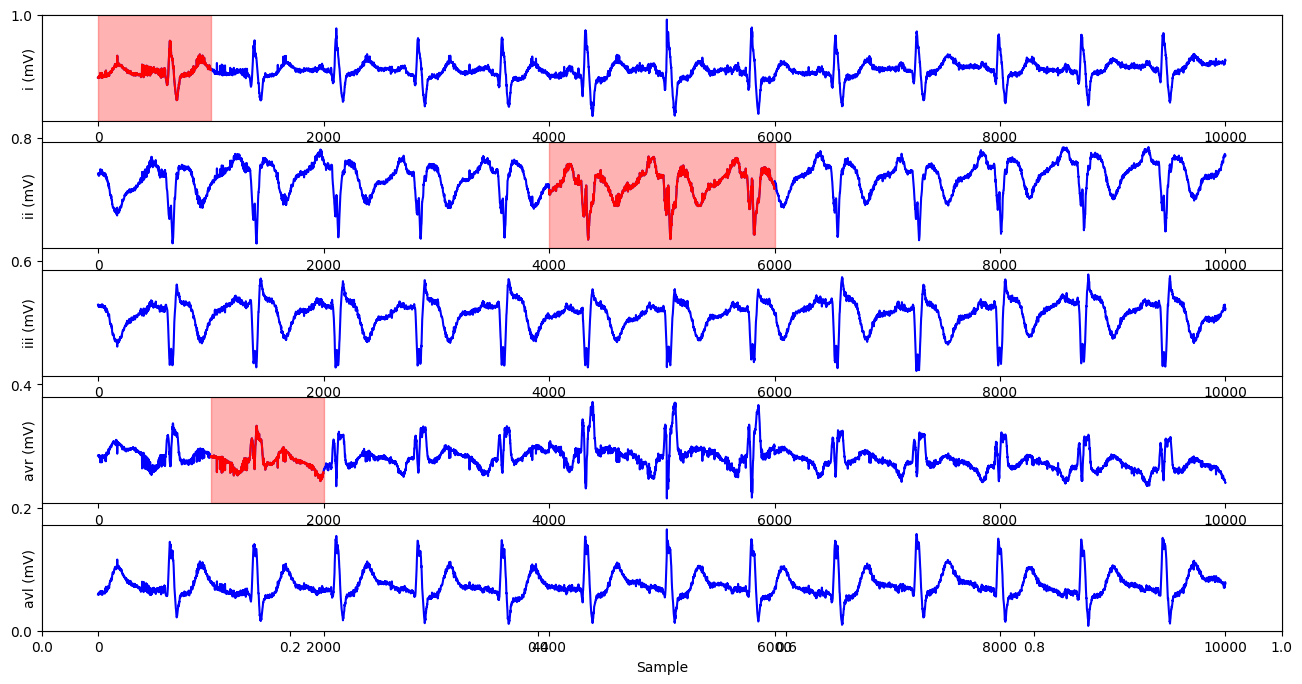

In [180]:
fig, ax = plt.subplots(figsize=(16, 8))
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1])

# Create each subplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)
axes = [ax0, ax1, ax2, ax3, ax4]


for i, (ax, data) in enumerate(zip(axes, leads_pred[:5])):
    # Plot points where channel_data_masked is nan as red
    nan_indices = jnp.isnan(channel_data_masked[i])
    
    # Plot the measured data in blue
    ax.plot(data, color='blue', label='Measured')

    # Plot the imputed data in red
    ax.plot(jnp.arange(len(data))[nan_indices], data[nan_indices], color='red', label='Imputed')


    for start_idx, end_idx in contiguous_regions(nan_indices):
        ax.axvspan(start_idx, end_idx, color='red', alpha=0.3)

    ax.set_ylabel(f"{channels[i]} (mV)")
    ax.set_yticks([])
    ax.set_xlabel("Sample");
    
# Save as pdf
fig.savefig("imputed.pdf")

In [158]:
channel_data

array([[-0.2445, -0.2425, -0.2415, ...,  0.0595,  0.0435,  0.043 ],
       [-0.229 , -0.2335, -0.2345, ...,  0.0465,  0.045 ,  0.046 ],
       [ 0.0155,  0.009 ,  0.007 , ..., -0.013 ,  0.0015,  0.003 ],
       ...,
       [ 0.106 ,  0.1095,  0.1095, ...,  0.0545,  0.0645,  0.062 ],
       [ 0.1965,  0.202 ,  0.2005, ...,  0.0505,  0.0575,  0.0565],
       [ 0.195 ,  0.198 ,  0.1965, ...,  0.057 ,  0.0645,  0.067 ]])

In [23]:
# Impute missing values using MAP estimate
s_post, p_post = z_post[:, :3], z_post[:, 3:]

eps = vmap(
    vmap(compute_electrode_electric_potential, (0, 0, None)), (None, None, 0)
)(s_post, p_post, r_post)
leads_pred = compute_lead_observations(eps)

In [24]:
leads_pred

Array([[ 4.2048001e-08,  6.4739083e-08,  4.3870205e-09, ...,
        -8.8892186e-08, -3.2302125e-08, -9.0235545e-08],
       [-5.3539466e-09, -5.8265609e-10,  6.5237776e-10, ...,
        -9.2172066e-09, -4.7428412e-09, -8.1756060e-09],
       [-4.7401947e-08, -6.5321743e-08, -3.7346428e-09, ...,
         7.9674983e-08,  2.7559285e-08,  8.2059934e-08],
       ...,
       [-2.4063072e-06, -1.4274373e-06,  1.7632717e-06, ...,
        -9.4181189e-07, -1.2962015e-06,  1.2965057e-07],
       [ 5.9126965e-03,  4.0427409e-03, -2.7411357e-03, ...,
         3.2232963e-03,  3.5141860e-03,  6.8555371e-04],
       [-1.3862609e-07, -7.6188186e-08,  4.1509661e-08, ...,
        -7.4631274e-08, -6.3402169e-08, -3.9312063e-08]], dtype=float32)

In [25]:
channel_data

array([[-0.2445, -0.2425, -0.2415, ...,  0.0595,  0.0435,  0.043 ],
       [-0.229 , -0.2335, -0.2345, ...,  0.0465,  0.045 ,  0.046 ],
       [ 0.0155,  0.009 ,  0.007 , ..., -0.013 ,  0.0015,  0.003 ],
       ...,
       [ 0.106 ,  0.1095,  0.1095, ...,  0.0545,  0.0645,  0.062 ],
       [ 0.1965,  0.202 ,  0.2005, ...,  0.0505,  0.0575,  0.0565],
       [ 0.195 ,  0.198 ,  0.1965, ...,  0.057 ,  0.0645,  0.067 ]])

In [21]:
# n_epochs = 10_000

# obs_mask = jnp.where(jnp.isnan(channel_data), 0., 1.)
# r_params, z_params = r_init, z_init

# for epoch in range(n_epochs):
#     r_params, z_params, log_joint = \
#         update_step(r_params, z_params, channel_data, obs_mask,
#                     lr=1e-3)
#     if epoch % 500 == 0:
#         print(f"Epoch: {epoch: <6} Log Joint: {int(log_joint):>20,}")

In [22]:
# n_epochs = 150_000

# obs_mask = jnp.where(jnp.isnan(channel_data_masked), 0., 1.)
# r_params, z_params = r_init, z_init

# for epoch in range(n_epochs):
#     r_params, z_params, log_joint = \
#         update_step(r_params, z_params, channel_data_masked, obs_mask,
#                     lr=1e-4)
#     if epoch % 1000 == 0:
#         print(f"Epoch: {epoch: <6} Log Joint: {int(log_joint):>20,}")

In [310]:
# Impute missing values using MAP estimate
r_post = r_params
s_post, p_post = z_params[:, :3], z_params[:, 3:]

eps = vmap(
    vmap(compute_electrode_electric_potential, (0, 0, None)), (None, None, 0)
)(s_post, p_post, r_post)
leads_pred = compute_lead_observations(eps)

In [193]:
mask = jnp.where(jnp.isnan(channel_data_masked), 1., 0.)
print(jnp.sum(jnp.sqrt((mask * leads_pred - mask * channel_data) ** 2)) / mask.sum())

0.00224261


In [181]:
leads_pred 

Array([[-0.16910401, -0.16729572, -0.1682677 , ...,  0.04458554,
         0.03430207,  0.03376155],
       [-0.12142873, -0.12654969, -0.12979656, ...,  0.02014881,
         0.02817968,  0.02923013],
       [ 0.04767528,  0.04074604,  0.03847112, ..., -0.02443673,
        -0.0061224 , -0.00453141],
       ...,
       [ 0.11125313,  0.11530341,  0.10580195, ...,  0.05666363,
         0.07107405,  0.06833605],
       [ 0.18908365,  0.19355173,  0.20841065, ...,  0.0566003 ,
         0.0563837 ,  0.05694211],
       [ 0.20005028,  0.20407705,  0.18712965, ...,  0.0397131 ,
         0.05920582,  0.06101896]], dtype=float32)

In [313]:
channel_data

array([[-0.2445, -0.2425, -0.2415, ...,  0.0595,  0.0435,  0.043 ],
       [-0.229 , -0.2335, -0.2345, ...,  0.0465,  0.045 ,  0.046 ],
       [ 0.0155,  0.009 ,  0.007 , ..., -0.013 ,  0.0015,  0.003 ],
       ...,
       [ 0.106 ,  0.1095,  0.1095, ...,  0.0545,  0.0645,  0.062 ],
       [ 0.1965,  0.202 ,  0.2005, ...,  0.0505,  0.0575,  0.0565],
       [ 0.195 ,  0.198 ,  0.1965, ...,  0.057 ,  0.0645,  0.067 ]])

## 2.2 Kappa fit

In [194]:
def predict_lead_obs(params):
    r, s, p, k = params["r"], params["s"], params["p"], params["k"]
    eps = vmap(
        vmap(compute_electrode_electric_potential, (0, 0, None, None)), (None, None, 0, None)
    )(s, p, r, k)
    leads_pred = compute_lead_observations(eps)
    
    return leads_pred

def rmse_loss(params, obs, obs_mask):
    leads_pred = predict_lead_obs(params)
    # print(leads_pred)
    loss = (leads_pred - obs)**2
    loss = loss * obs_mask
    loss = jnp.sqrt(loss.mean())
    
    return loss

@jit
def update_step_rmse(state, obs, obs_mask):
    loss, grads = value_and_grad(rmse_loss)(state.params, obs, obs_mask)
    state = state.apply_gradients(grads=grads)
    
    return state, loss

def train_rmse(params, obs, lr=1e-5, n_epochs=1_000):
    mask = jnp.where(jnp.isnan(obs), 0., 1.)
    obs = jnp.where(jnp.isnan(obs), 0., obs)
    
    predictions = predict_lead_obs(params)
    # print(f"predictions: {predictions[:,:5]}")
    # print(f"observed: {obs[:,:5]}")
    # print(f"loss: {(predictions - obs)**2}\n\n")
    
    # Train state
    lr_schedule = optax.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=lr,
        warmup_steps=n_epochs//10,
        decay_steps=n_epochs,
        end_value=1e-6
    )
    optimizer = optax.adam(lr_schedule)
    state = train_state.TrainState.create(
        apply_fn=None, params=params, tx=optimizer
    )
    
    for epoch in range(n_epochs):
        state, loss = update_step_rmse(state, obs, mask)
        if epoch % 200 == 0:
            print(f"Epoch {epoch: >6} | Loss: {loss:>10}")
        # predictions = predict_lead_obs(state.params)
        # print(f"predictions: {predictions[:,:5]}")
        # print(f"observed: {obs[:,:5]}\n")
        # print(f"loss: {(predictions - obs)**2}")
        
    predictions = predict_lead_obs(state.params)
    
    return state

In [197]:
n_steps = 10_000

keys = jr.split(jr.PRNGKey(0), 4)
n_electrodes = 9
r_init = jr.normal(keys[0], (n_electrodes, 3))
s_init, p_init = \
    jr.normal(keys[1], (n_steps, 3)), jr.normal(keys[2], (n_steps, 3))
k_init = jr.normal(keys[3])

params = {
    "r": r_init,
    "s": s_init,
    "p": p_init,
    "k": k_init
}

In [198]:
state_post_masked = train_rmse(params, channel_data_masked, lr=1e-1, n_epochs=30_000)

Epoch      0 | Loss: 0.39116477966308594
Epoch    200 | Loss: 0.18085245788097382
Epoch    400 | Loss: 0.14733392000198364
Epoch    600 | Loss: 0.12582962214946747
Epoch    800 | Loss: 0.11433717608451843
Epoch   1000 | Loss: 0.10161703824996948
Epoch   1200 | Loss: 0.08208627253770828
Epoch   1400 | Loss: 0.07279281318187714
Epoch   1600 | Loss: 0.06603986024856567
Epoch   1800 | Loss: 0.06111826002597809
Epoch   2000 | Loss: 0.05581606924533844
Epoch   2200 | Loss: 0.053201641887426376
Epoch   2400 | Loss: 0.05049283057451248
Epoch   2600 | Loss: 0.049611374735832214
Epoch   2800 | Loss: 0.04949399083852768
Epoch   3000 | Loss: 0.05309475213289261
Epoch   3200 | Loss: 0.047471411526203156
Epoch   3400 | Loss: 0.04515331611037254
Epoch   3600 | Loss: 0.0428302139043808
Epoch   3800 | Loss: 0.04345061630010605
Epoch   4000 | Loss: 0.04267144948244095
Epoch   4200 | Loss: 0.04144396632909775
Epoch   4400 | Loss: 0.04151404649019241
Epoch   4600 | Loss: 0.04147239401936531
Epoch   4800 |

In [202]:
state_post_masked.params

{'k': Array(0.12383606, dtype=float32),
 'p': Array([[ 9.470256  , -1.7102028 , -3.260597  ],
        [ 9.92482   , -1.7078433 , -3.041504  ],
        [ 9.788688  , -1.8012582 , -3.005333  ],
        ...,
        [ 0.14933455, -0.33056384, -0.25558257],
        [ 0.15415256, -0.24709931, -0.1772967 ],
        [ 3.8638437 , -6.2647815 ,  0.16871136]], dtype=float32),
 'r': Array([[-1.2644633 , -1.7964658 ,  2.0759435 ],
        [-0.1461525 ,  2.6334758 ,  1.4015094 ],
        [ 0.3106015 ,  0.9121689 , -0.9221392 ],
        [-0.65788484,  1.5076847 ,  0.10289007],
        [-0.22763726,  0.63045603,  0.05408059],
        [ 0.51574844,  0.28908694,  0.19082613],
        [ 1.0988772 ,  0.26204374,  0.06251238],
        [ 1.4215438 ,  0.585398  , -0.21321209],
        [ 1.628736  ,  0.76607925, -0.11844406]], dtype=float32),
 's': Array([[ 0.4116854 , -1.961141  , -1.7438667 ],
        [ 0.4619964 , -1.9890347 , -1.7664727 ],
        [ 0.44900015, -1.9880248 , -1.7429526 ],
        ...,
   

In [199]:
leads_pred = predict_lead_obs(state_post_masked.params)
leads_pred

Array([[-0.1669063 , -0.16526371, -0.16441028, ...,  0.03318034,
         0.02523862,  0.03320215],
       [-0.11971447, -0.12489708, -0.12623164, ...,  0.0138046 ,
         0.02148472,  0.02918849],
       [ 0.04719183,  0.04036663,  0.03817864, ..., -0.01937575,
        -0.0037539 , -0.00401366],
       ...,
       [ 0.10129382,  0.10553125,  0.10478694, ...,  0.05291945,
         0.05800354,  0.05349938],
       [ 0.18586157,  0.1894968 ,  0.18817167, ...,  0.06738273,
         0.07569438,  0.06069142],
       [ 0.20686737,  0.2112922 ,  0.20993096, ...,  0.03093689,
         0.04078869,  0.06354732]], dtype=float32)

In [200]:
mask = jnp.where(jnp.isnan(channel_data_masked), 1., 0.)
print(jnp.sum(jnp.sqrt((mask * leads_pred - mask * channel_data) ** 2)) / mask.sum())

0.032108013
